In [1]:
import mpmath as mpm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.dpi"] = 150

from qiskit import QuantumCircuit
from qiskit import Aer,execute, QuantumRegister,ClassicalRegister
from qiskit.visualization import plot_histogram

from qiskit import IBMQ
from qiskit import transpile
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)

In [2]:
def Chbshv_poly(L, x): # Lth Chebyshev polynomial of the first kind
    return mpm.cos(L * mpm.acos(x))

def oracle(qc,n, indices_to_mark):
    # create a quantum circuit on n qubits
    index_bit =  format(indices_to_mark, "0{:d}b".format(n))
    qc.barrier()
    for i in range(n):
        if index_bit[i] == '0':
            qc.x(n-i) # Measurement order is the reversed qubit order
    qc.mct(list(range(n,0,-1)), 0)
    for i in range(n): # Redo the NOT gates applied on control qubits
        if index_bit[i] == '0':
            qc.x(n-i) # Measurement order is the reversed qubit order
    qc.barrier()
    
    
def FP_Grover_circuit(n, indices_to_mark, itr, d, return_params = False):
    # Does not include measurements to allow state tomography
    l = itr
    L = 2*l+1

    gamma_inverse = Chbshv_poly(1/L, 1/d)
    omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

    alpha =  mpm.zeros(1,l)
    beta = mpm.zeros(1,l)
    for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
        alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
        beta[l-(i+1)+1-1] = -alpha[i]

    # Convert to numpy
    gamma_inverse = np.array([gamma_inverse], dtype=complex)[0].real
    omega = np.array([omega], dtype=complex)[0].real
    alpha = np.array(alpha.tolist()[0], dtype=complex).real
    beta = np.array(beta.tolist()[0], dtype=complex).real
    
    r = QuantumRegister(n+1)
    qc = QuantumCircuit(r)
    # Initialize |s>
    for i in range(n):
        qc.h(n-i) # Measurement order is the reversed qubit order
    for i in range(itr):
        # St(beta)
        oracle(qc,n, indices_to_mark) # turn state into |T>|1> + sum_i (|w_i>|0>) where w_i are NOT target state, T is the target state
        qc.p(beta[i],0) # when beta[i] = pi, this is simply a Z gate, so only has phase kickback on |T>|1> but not |w_i>|0>
        oracle(qc,n, indices_to_mark)  # to uncompute the ancillary
        # St(alpha)
        for q in range(n):
            qc.h(n-q)
        qc.barrier()
        for q in range(n-1):
            qc.x(n-q)
        qc.p(-alpha[i]/2, 1)
        qc.mct(list(range(n, 1, -1)), 1)
        qc.mct(list(range(n, 1, -1)), 0)
        qc.p(-alpha[i]/2, 1)
        qc.p(-alpha[i]/2, 0)
        qc.mct(list(range(n, 1, -1)), 1)
        qc.mct(list(range(n, 1, -1)), 0)
        for q in range(n-1):
            qc.x(n-q)
        qc.p(alpha[i], 1)
        qc.barrier()
        for q in range(n):
            qc.h(n-q)
    if return_params:
        return qc, (gamma_inverse, 1/2**n, omega, alpha, beta)
    else:
        return qc

# A single-iteration 2-qubit fixed-point Grover's search example whose target is 2 (i.e., |10>)

Here, $\lambda = \frac{\text{Number of Marked Items}}{\text{Number of Total Items}} = \frac{1}{2^n}$. The computation of other parameters follows formulas in the Yoder's paper. Note that $n$ here does not include the ancilla qubit.

gamma^{-1} = 1.118033988749895
lambda =  0.25
omega =  0.20000000000000007
alphas: [-1.82347658]
betas: [1.82347658]

Circuit depth is 17
Searching for  10
If lambda > omega, P_L >= 1-delta^2 =  0.8


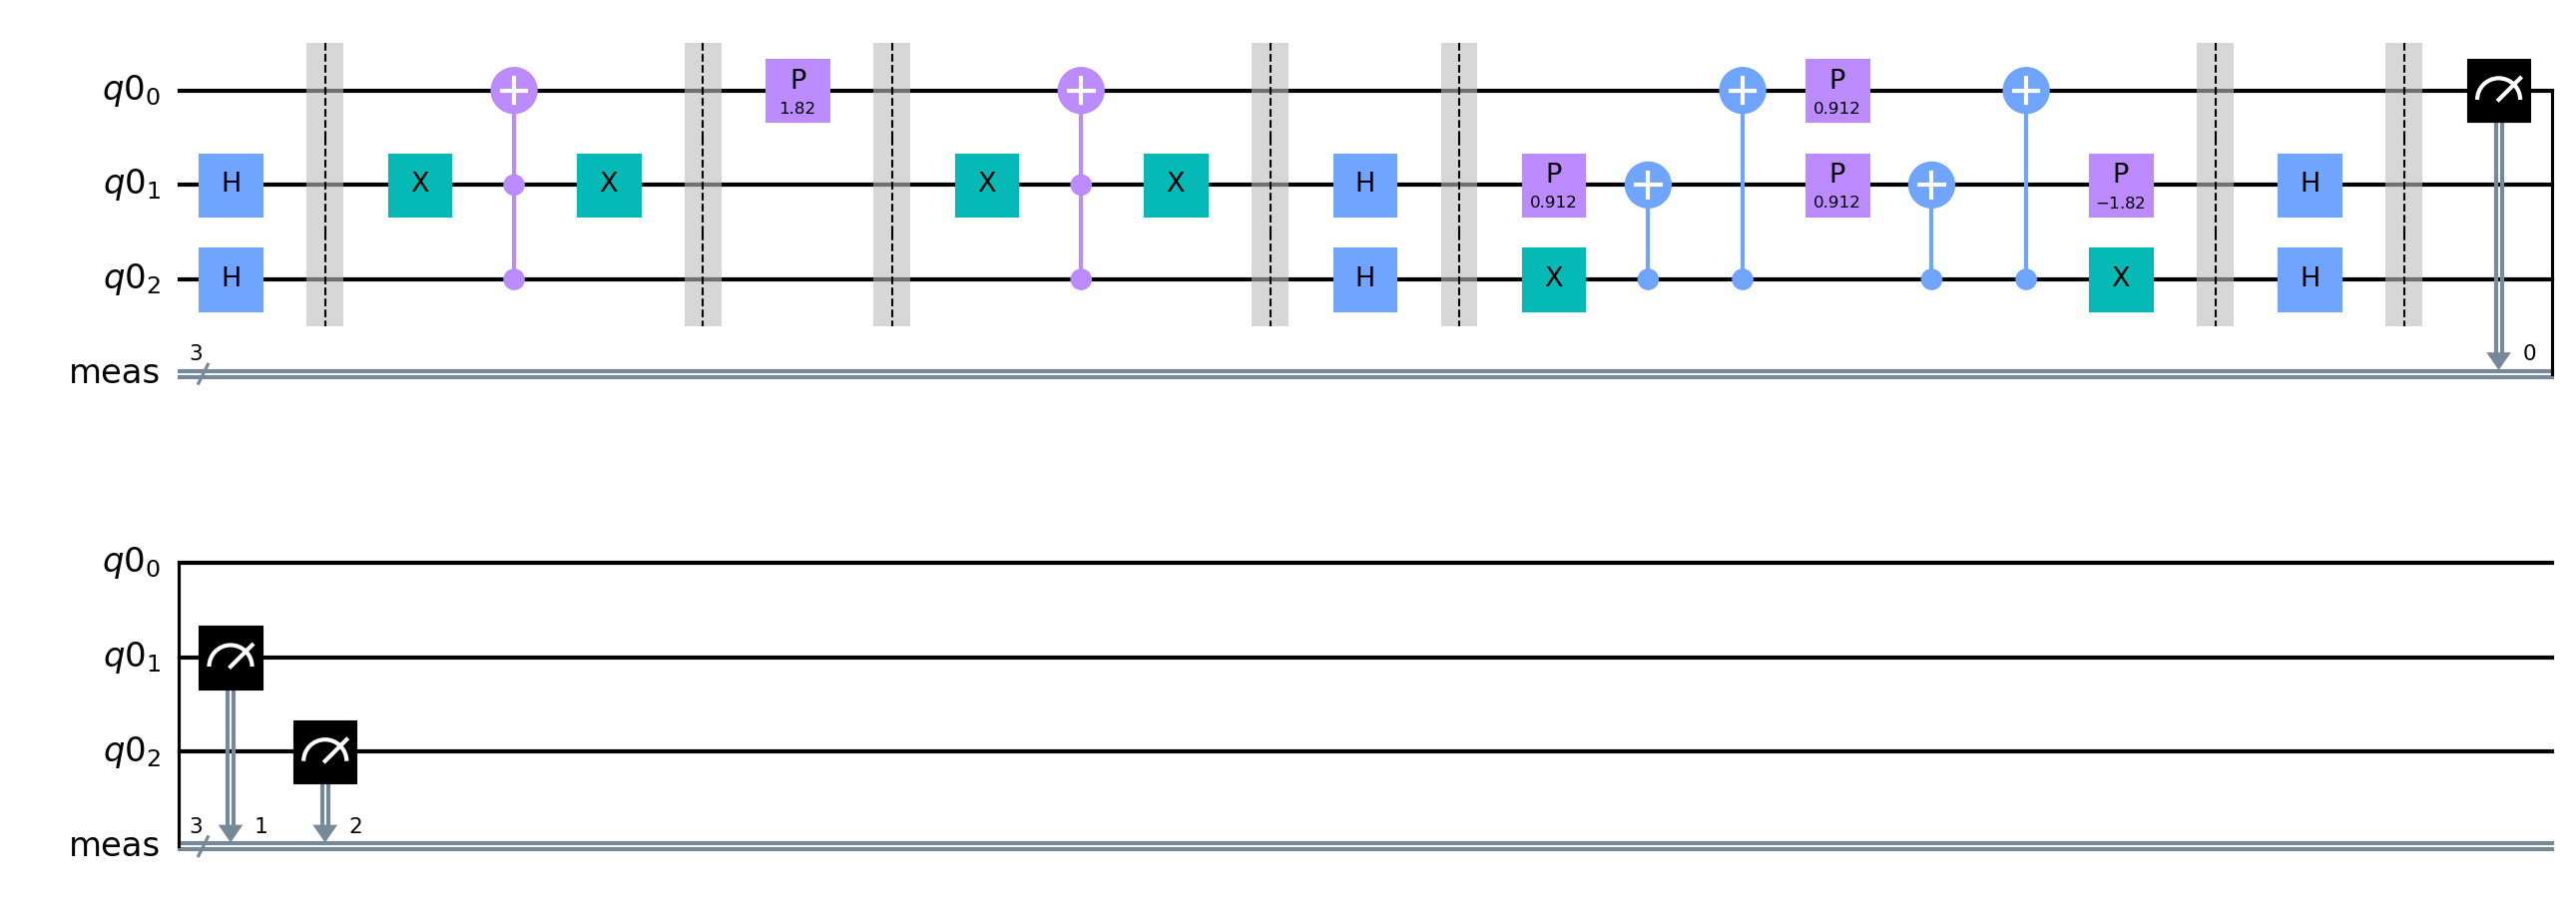

In [3]:
# Input parameters for the Fixed-Point Grover's search
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 2 # An interger from 0 to 2**n

itr = 1 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

grover_qc, (gamma_inverse, lam, omega, alpha, beta) = FP_Grover_circuit(n, indices_to_mark, itr, d, return_params = True)
grover_qc.measure_all()

print("gamma^{-1} =", gamma_inverse)
print("lambda = ", lam)
print("omega = ", omega)
print("alphas:", alpha)
print("betas:", beta)

print("\nCircuit depth is", grover_qc.depth())
print("Searching for ", format(indices_to_mark, "0{:d}b".format(n)))
print("If lambda > omega, P_L >= 1-delta^2 = ", 1-d**2)
grover_qc.draw("mpl")

Running on the simulator for 8192 times

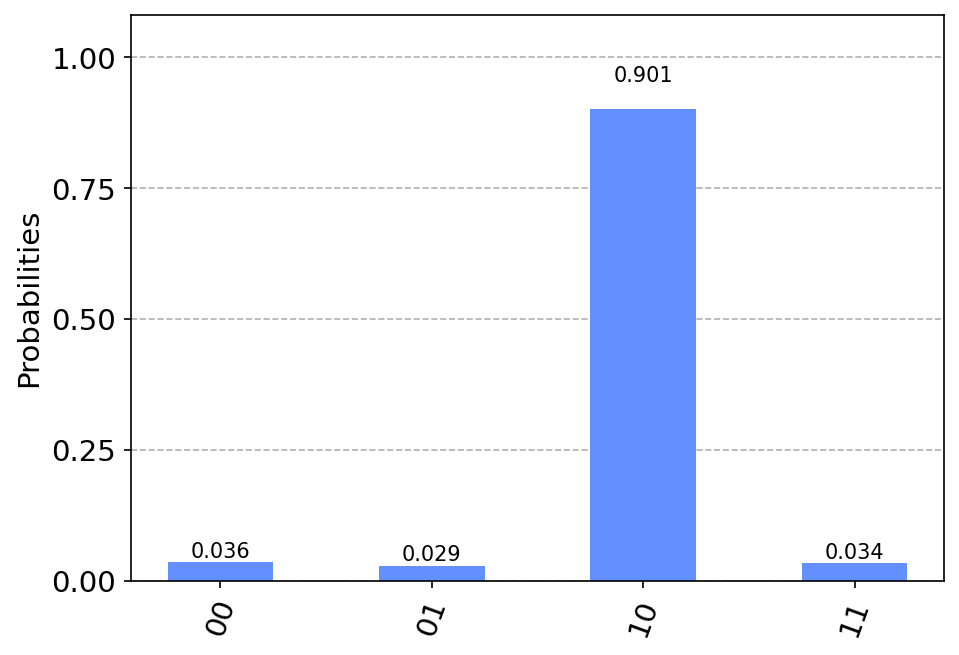

In [4]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=8192).result().get_counts()
no_acillary_counts = {key[0:n]:item for key, item in counts.items()} # Remove ancillary (last binary)
plot_histogram(no_acillary_counts)
# succ_prob = counts[(format(indices_to_mark, '0{:d}b'.format(n)))]/shots

# Behaviors of the Algorithm

In [5]:
def FP_Grover_simulator(n, indices_to_mark, itr, d, shots=10000):    
    grover_qc, (gamma_inverse, lam, omega, alpha, beta) = FP_Grover_circuit(n, indices_to_mark, itr, d, return_params = True)
    grover_qc.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(grover_qc, backend=simulator, shots=shots).result().get_counts()
    no_acillary_counts = {key[0:n]:item for key, item in counts.items()} # Remove ancillary (last binary)
    succ_prob = no_acillary_counts[format(indices_to_mark, '0{:d}b'.format(n))]/shots

    return succ_prob, omega

## Increase of $P_L$ when the number of iterations increases for a 5-qubit FP Grover

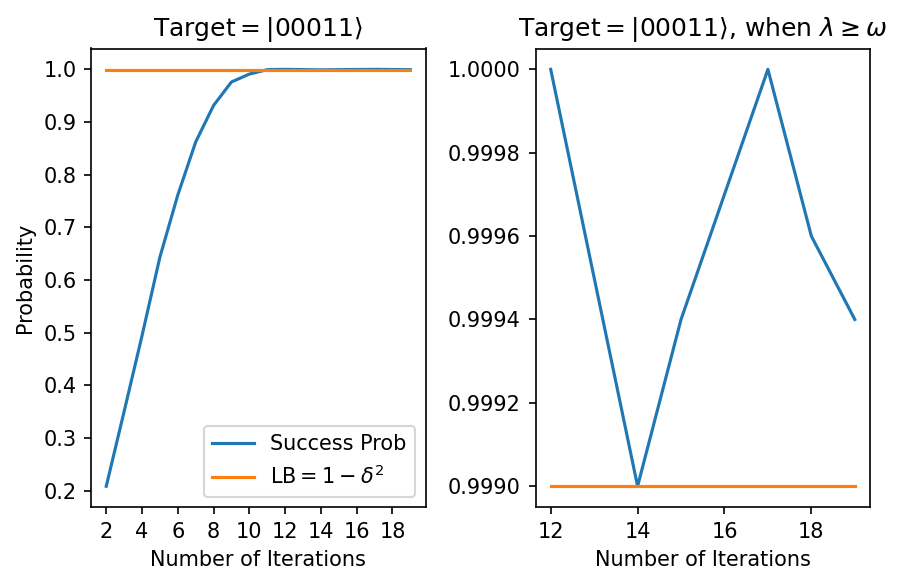

In [6]:
n = 5
index_to_mark = 3
d = np.sqrt(0.001)
itrs = np.array(list(range(2,20)))

probs = np.zeros(len(itrs), dtype=np.float64)
omegas = np.zeros(len(itrs), dtype=np.float64)
for i in range(len(itrs)):
    succ_prob, omega = FP_Grover_simulator(n, index_to_mark, int(itrs[i]), d, shots=10000)
    probs[i] = succ_prob
    omegas[i] = omega

plt.subplot(1, 2, 1)
plt.plot(itrs, probs, label="Success Prob")
plt.plot(itrs, 1-np.square([d]*len(itrs)), label="LB$=1-\delta^2$")
plt.xlabel("Number of Iterations")
plt.ylabel("Probability")
plt.xticks(itrs[::2])
plt.legend()
plt.title(r"Target$=|${:s}$\rangle$".format(format(index_to_mark, "0{:d}b".format(n))))
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(itrs[(1/2**n)>= omegas], probs[(1/2**n)>= omegas], label="Success Prob")
plt.plot(itrs[(1/2**n)>= omegas], 1-np.square([d]*len(itrs))[(1/2**n)>= omegas], label="LB$=1-\delta^2$")
plt.xlabel("Number of Iterations")
plt.xticks(itrs[(1/2**n)>= omegas][::2])
plt.title(r"Target$=|${:s}$\rangle$, when $\lambda \geq \omega$".format(format(index_to_mark, "0{:d}b".format(n))))
plt.tight_layout()

plt.show()

## The change of $P_L$ when the numebr of iterations and qubits changes

In [7]:
index_to_mark = 3
ns = list(range(3, 10)) # Number of Qubits
ls = list(range(1,41)) # Number of Iterations
d = np.sqrt(0.01)

N,L = np.meshgrid(ns, ls)
probs = np.zeros(N.shape, dtype = np.float64)
omegas = np.zeros(N.shape, dtype = np.float64)
lambdas = np.zeros(N.shape, dtype = np.float64)
for j in range(len(ns)):
    for i in range(len(ls)):
        succ_prob, omega =FP_Grover_simulator(ns[j], index_to_mark, ls[i], d, shots=10000)
        probs[i,j] = succ_prob
        omegas[i,j] = omega
        lambdas[i,j] = 1/2**ns[j]
        print('Progress: {:.3%}'.format((j*len(ls)+i)/(len(ns)*len(ls))), end='\r')

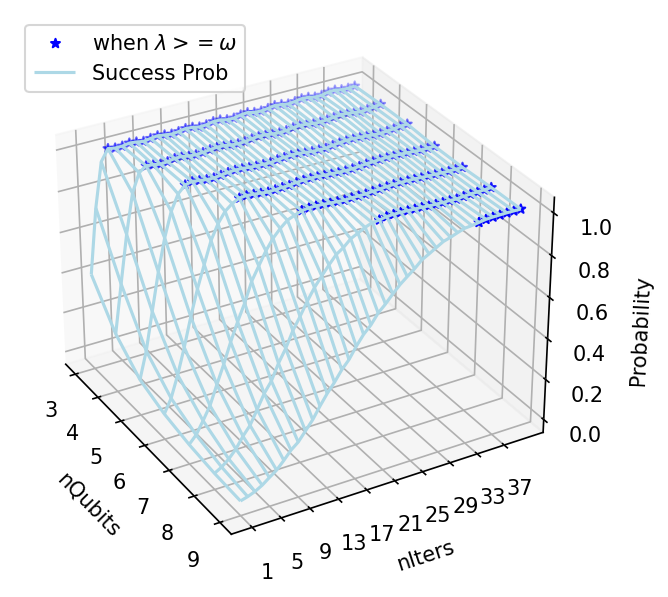

In [8]:
fig = plt.figure()
ax =  fig.add_subplot( projection='3d')
ax.scatter3D(N[lambdas>=omegas], L[lambdas>=omegas], probs[lambdas>=omegas], marker='*', color='blue',label=r'when $\lambda >= \omega$')
ax.plot_wireframe(N, L, probs, color = 'lightblue', rstride=1, cstride=1, label="Success Prob")
ax.set_xlabel('nQubits')
ax.set_xticks(ns)
ax.set_ylabel('nIters')
ax.set_yticks(ls[0::4])
ax.set_zlabel('Probability')

ax.view_init(elev=30, azim=330)
plt.tight_layout()
plt.legend()
plt.show()